In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [ ]:


hd_pct = 0.001

strategy_name = '中位小高开起爆'
days = 5
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 2,
        "top_cx": 50,
        "only_fx": True,
        "enbale_industry": False,
        "empty_priority": False
      },
      
        ]

filter_count = 0
filter_amount = 8000000
gap = 0
rank_filter = True

In [5]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        print(f"error: {stock_code}-{datekey}-{len(amount)}")
        real_amount = 0

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [6]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [7]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [8]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,1645,2024-09-02,追涨,小高开追涨,600818.XSHG,中路股份,1,"000012.BKDL,000035.BKDL,000027.BKDL,000019.BKD...","885520.DDBK,885791.DDBK,885641.DDBK,885974.DDB...",980372.ZHBK,...,小高开追涨,-35.33,1.65,46,-79.59,10.57,55,"{""9A0001"": {""realShortLineScore"": 23.04, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 20:11:37
1,1657,2024-09-04,追涨,小高开追涨,600611.XSHG,大众交通,1,"000003.BKDL,000015.BKDL,000027.BKDL,000019.BKD...","885887.DDBK,885620.DDBK,885766.DDBK,885753.DDB...",980339.ZHBK,...,小高开追涨,-39.18,2.21,44,-81.11,1.59,55,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 20:13:26
2,1658,2024-09-04,追涨,小高开追涨,001373.XSHE,翔腾新材,2,"000026.BKDL,000023.BKDL,000006.BKDL,000032.BKD...","885840.DDBK,885875.DDBK,885598.DDBK,885806.DDB...",980357.ZHBK,...,小高开追涨,-39.18,2.21,44,-81.11,1.59,55,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 20:13:26
3,1701,2024-09-12,追涨,小高开追涨,002878.XSHE,元隆雅图,1,"000012.BKDL,000021.BKDL,000003.BKDL,000014.BKD...","885933.DDBK,886017.DDBK,886014.DDBK,885806.DDB...","980353.ZHBK,980473.ZHBK,980355.ZHBK",...,小高开追涨,85.03,107.77,3,-16.60,8.08,35,"{""9A0001"": {""realShortLineScore"": -32.16, ""rea...","{""000009.BKDL"": {""categoryCode"": ""000009.BKDL""...",2025-02-15 20:18:53
4,1721,2024-09-13,追涨,小高开追涨,000702.XSHE,正虹科技,1,"000024.BKDL,000026.BKDL,000023.BKDL,000010.BKD...","885620.DDBK,885739.DDBK,885951.DDBK,886021.DDB...",980371.ZHBK,...,小高开追涨,86.33,1.30,3,-3.70,8.46,27,"{""9A0001"": {""realShortLineScore"": -39.04, ""rea...","{""000035.BKDL"": {""categoryCode"": ""000035.BKDL""...",2025-02-15 20:19:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2391,2025-03-17,追涨,小高开追涨,601789.XSHG,宁波建工,1,"000003.BKDL,000038.BKDL,000008.BKDL,000023.BKD...","885338.DDBK,886087.DDBK,886021.DDBK,885757.DDB...",980338.ZHBK,...,小高开追涨,59.65,-4.63,30,-23.14,9.22,35,"{""9A0001"": {""realShortLineScore"": 51.76, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-18 08:02:10
127,2523,2025-03-18,追涨,小高开追涨,603466.XSHG,风语筑,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","886100.DDBK,885933.DDBK,885867.DDBK,885816.DDB...","980338.ZHBK,980355.ZHBK,980348.ZHBK",...,小高开追涨,-9.47,-100.86,40,-28.49,-18.17,35,"{""9A0001"": {""realShortLineScore"": 51.82, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-19 08:02:07
128,2524,2025-03-18,追涨,小高开追涨,001339.XSHE,智微智能,2,"000012.BKDL,000008.BKDL,000023.BKDL,000016.BKD...","886100.DDBK,885459.DDBK,885861.DDBK,885517.DDB...",980366.ZHBK,...,小高开追涨,-9.47,-100.86,40,-28.49,-18.17,35,"{""9A0001"": {""realShortLineScore"": 51.82, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-19 08:02:07
129,2525,2025-03-18,追涨,小高开追涨,002846.XSHE,英联股份,3,"000023.BKDL,000035.BKDL,000033.BKDL,000029.BKDL","885869.DDBK,885710.DDBK,885929.DDBK,886020.DDB...",980373.ZHBK,...,小高开追涨,-9.47,-100.86,40,-28.49,-18.17,35,"{""9A0001"": {""realShortLineScore"": 51.82, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-19 08:02:07


In [9]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [10]:
combined_df = combined_df.reset_index(drop=True)

In [11]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '追涨']

In [12]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
121,1706,2025-03-11,追涨,小高开追涨,002929.XSHE,润建股份,2,"000012.BKDL,000026.BKDL,000018.BKDL,000019.BKD...","885517.DDBK,885461.DDBK,886062.DDBK,885564.DDB...","980753.ZHBK,980376.ZHBK",1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,133.24,1.18,0.68,59.02,62.06,-1.0,62.06,63.10,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,1.85,-16.99,17,-55.27,-8.96,44,2025-03-12 08:02:35
122,1861,2025-03-12,追涨,小高开追涨,603270.XSHG,金帝股份,1,"000035.BKDL,000011.BKDL,000027.BKDL,000032.BKD...","885641.DDBK,885598.DDBK,885775.DDBK,885929.DDB...",980365.ZHBK,1,1,8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0.0,107.62,3.40,0.63,28.88,29.07,-1.0,29.44,27.24,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,76.06,-4.45,14,-30.85,-2.28,41,2025-03-13 08:02:37
123,1862,2025-03-12,追涨,小高开追涨,002093.XSHE,国脉科技,2,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885522.DDBK,885617.DDBK,886041.DDBK,885456.DDB...","980753.ZHBK,980473.ZHBK,980376.ZHBK",2,2,2,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0.0,0.0,152.29,1.42,0.18,11.38,12.06,-1.0,11.73,13.27,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,76.06,-4.45,14,-30.85,-2.28,41,2025-03-13 08:02:37
124,2036,2025-03-13,追涨,小高开追涨,603190.XSHG,亚通精工,1,"000027.BKDL,000032.BKDL","885598.DDBK,885906.DDBK,885467.DDBK,886000.DDB...",980372.ZHBK,1,1,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0.0,118.27,2.55,0.57,24.62,23.75,-1.0,23.86,23.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,75.37,-9.87,13,-24.05,2.75,40,2025-03-14 08:02:38
125,2219,2025-03-14,追涨,小高开追涨,002358.XSHE,森源电气,1,"000035.BKDL,000023.BKDL,000018.BKDL,000011.BKD...","885571.DDBK,886021.DDBK,885867.DDBK,885517.DDB...",980474.ZHBK,2,7,21,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,139.93,3.26,0.76,6.64,6.43,-1.0,6.40,6.46,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,80.19,22.86,17,-26.09,4.51,37,2025-03-17 08:02:16
126,2391,2025-03-17,追涨,小高开追涨,601789.XSHG,宁波建工,1,"000003.BKDL,000038.BKDL,000008.BKDL,000023.BKD...","885338.DDBK,886087.DDBK,886021.DDBK,885757.DDB...",980338.ZHBK,1,16,33,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,7,0.0,0.0,184.69,1.04,0.15,6.77,6.88,-1.0,6.80,7.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,59.65,-4.63,30,-23.14,9.22,35,2025-03-18 08:02:10
127,2523,2025-03-18,追涨,小高开追涨,603466.XSHG,风语筑,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","886100.DDBK,885933.DDBK,885867.DDBK,885816.DDB...","980338.ZHBK,980355.ZHBK,980348.ZHBK",1,4,29,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0.0,130.51,2.49,0.97,11.40,11.60,-1.0,11.67,12.10,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-9.47,-100.86,40,-28.49,-18.17,35,2025-03-19 08:02:07
128,2524,2025-03-18,追涨,小高开追涨,001339.XSHE,智微智能,2,"000012.BKDL,000008.BKDL,000023.BKDL,000016.BKD...","886100.DDBK,885459.DDBK,885861.DDBK,885517.DDB...",980366.ZHBK,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,101.37,1.79,0.28,64.16,62.73,-1.0,61.87,61.28,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-9.47,-100.86,40,-28.49,-18.17,35,2025-03-19 08:02:07
129,2525,2025-03-18,追涨,小高开追涨,002846.XSHE,英联股份,3,"000023.BKDL,000035.BKDL,000033.BKDL,000029.BKDL","885869.DDBK,885710.DDBK,885929.DDBK,886020.DDB...",980373.ZHBK,2,8,28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,151.42,1.29,0.90,11.22,10.63,-1.0,10.60,10.29,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-9.47

In [13]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 600818.SH 日期 2024-09-02 过滤原因： first_tick_amount 8035832.0
过滤股票 001373.SZ 日期 2024-09-04 过滤原因： first_tick_amount 1721485.0
过滤股票 002878.SZ 日期 2024-09-12 过滤原因： first_tick_amount 9135816.0
过滤股票 000702.SZ 日期 2024-09-13 过滤原因： first_tick_amount 5147160.0
过滤股票 603721.SH 日期 2024-09-25 过滤原因： first_tick_amount 9014170.0
过滤股票 001226.SZ 日期 2024-09-26 过滤原因： first_tick_amount 4975432.0
过滤股票 001229.SZ 日期 2024-09-27 过滤原因： first_tick_amount 6585590.0
过滤股票 001318.SZ 日期 2024-09-27 过滤原因： first_tick_amount 2849040.0
过滤股票 603310.SH 日期 2024-09-30 过滤原因： first_tick_amount 5478673.0
过滤股票 001239.SZ 日期 2024-09-30 过滤原因： first_tick_amount 2331342.0
过滤股票 603004.SH 日期 2024-09-30 过滤原因： first_tick_amount 3087744.0
过滤股票 001389.SZ 日期 2024-09-30 过滤原因： first_tick_amount 3384224.0
过滤股票 000637.SZ 日期 2024-10-08 过滤原因： first_tick_amount 4890897.0
过滤股票 000037.SZ 日期 2024-10-08 过滤原因： first_tick_amount 7478120.0
过滤股票 002640.SZ 日期 2024-10-14 过滤原因： first_tick_amount 7620102.0
过滤股票 603261.SH 日期 2024-10-22 过滤原因： first_tick_amount 35

C:\Users\Administrator\AppData\Local\Temp\ipykernel_41520\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,1657,追涨,小高开追涨,600611.XSHG,大众交通,1,"000003.BKDL,000015.BKDL,000027.BKDL,000019.BKD...","885887.DDBK,885620.DDBK,885766.DDBK,885753.DDB...",980339.ZHBK,1,8,20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,200.18,5.89,1.20,9.31,9.45,-1.0,9.30,10.40,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-39.18,2.21,44,-81.11,1.59,55,2025-02-15 20:13:26,57912855.0,-0.001074,-0.002074,0.117078,0.116078
2024-09-25,1801,追涨,小高开追涨,600825.XSHG,新华传媒,2,"000012.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","886021.DDBK,885787.DDBK,885413.DDBK,885768.DDB...","980355.ZHBK,980348.ZHBK",1,7,7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,177.42,7.71,4.45,4.69,4.44,-1.0,4.40,4.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,89.10,90.26,20,32.51,19.70,28,2025-02-15 20:25:28,14247751.0,-0.061834,-0.062834,-0.034115,-0.035115
2024-09-27,1840,追涨,小高开追涨,002902.XSHE,铭普光磁,3,"000003.BKDL,000038.BKDL,000026.BKDL,000035.BKD...","885908.DDBK,886073.DDBK,885990.DDBK,885521.DDB...",980376.ZHBK,1,4,44,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,193.89,3.59,1.59,18.54,19.32,-1.0,20.35,21.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,51.39,-13.30,36,30.81,-0.85,37,2025-02-15 20:27:26,10458414.0,0.097627,0.096627,0.141316,0.140316
2024-09-30,1869,追涨,小高开追涨,001339.XSHE,智微智能,1,"000012.BKDL,000008.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885861.DDBK,885517.DDBK,885759.DDB...",980366.ZHBK,1,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,185.59,24.47,3.54,33.90,36.01,-1.0,39.61,39.61,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,97.77,46.38,29,56.92,12.52,31,2025-02-15 20:28:36,11651430.0,0.168437,0.167437,0.168437,0.167437
2024-10-08,1044,追涨,小高开追涨,600988.XSHG,赤峰黄金,2,"000038.BKDL,000026.BKDL,000023.BKDL,000011.BKD...","885284.DDBK,885520.DDBK,885869.DDBK,885840.DDB...",980335.ZHBK,1,7,100,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,232.89,13.80,6.35,21.45,19.64,-1.0,19.00,17.97,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,119.65,21.88,21,92.45,17.75,31,2025-02-15 20:30:10,105876578.0,-0.114219,-0.115219,-0.162238,-0.163238
2024-10-18,1165,追涨,小高开追涨,603516.XSHG,淳中科技,1,"000012.BKDL,000008.BKDL,000006.BKDL,000031.BKD...","885423.DDBK,885806.DDBK,885378.DDBK,885675.DDB...",980366.ZHBK,1,3,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,171.62,4.07,6.38,30.50,31.54,-1.0,32.80,33.13,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,65.26,-6.27,23,55.32,-0.23,37,2025-02-15 20:38:05,13468800.0,0.075410,0.074410,0.086230,0.085230
2024-10-22,1189,追涨,小高开追涨,002829.XSHE,星网宇达,2,"000012.BKDL,000008.BKDL,000038.BKDL,000027.BKD...","885743.DDBK,885517.DDBK,885929.DDBK,885574.DDB...",980363.ZHBK,2,1,48,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,10,0.0,0.0,214.47,9.00,1.96,19.78,19.15,-1.0,19.03,19.95,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,104.95,19.81,10,86.21,-2.10,28,2025-02-15 20:40:05,10896802.0,-0.037917,-0.038917,0.008595,0.007595
2024-10-25,1262,追涨,小高开追涨,002865.XSHE,钧达股份,1,"000038.BKDL,000023.BKDL,000035.BKDL,000027.BKD...","885869.DDBK,885694.DDBK,885894.DDBK,883304.DDB...","980372.ZHBK,980474.ZHBK",2,4,30,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,0.0,165.61,6.01,

In [14]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_41520\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [15]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-04,9.31,10.40,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-25,4.69,4.53,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-27,18.54,21.16,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-30,33.90,39.61,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-08,21.45,17.97,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-18,30.50,33.13,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-22,19.78,19.95,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-25,55.82,65.58,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-28,3.10,3.05,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [16]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [17]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,1657,追涨,小高开追涨,600611.XSHG,大众交通,1,"000003.BKDL,000015.BKDL,000027.BKDL,000019.BKD...","885887.DDBK,885620.DDBK,885766.DDBK,885753.DDB...",980339.ZHBK,1,8,20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,200.18,5.89,1.20,9.31,9.45,-1.0,9.30,10.40,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-39.18,2.21,44,-81.11,1.59,55,2025-02-15 20:13:26,57912855.0,-0.001074,-0.002074,0.117078,0.116078,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.30
2024-09-25,1801,追涨,小高开追涨,600825.XSHG,新华传媒,2,"000012.BKDL,000023.BKDL,000010.BKDL,000015.BKD...","886021.DDBK,885787.DDBK,885413.DDBK,885768.DDB...","980355.ZHBK,980348.ZHBK",1,7,7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,177.42,7.71,4.45,4.69,4.44,-1.0,4.40,4.53,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,89.10,90.26,20,32.51,19.70,28,2025-02-15 20:25:28,14247751.0,-0.061834,-0.062834,-0.034115,-0.035115,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.70
2024-09-27,1840,追涨,小高开追涨,002902.XSHE,铭普光磁,3,"000003.BKDL,000038.BKDL,000026.BKDL,000035.BKD...","885908.DDBK,886073.DDBK,885990.DDBK,885521.DDB...",980376.ZHBK,1,4,44,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,193.89,3.59,1.59,18.54,19.32,-1.0,20.35,21.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,51.39,-13.30,36,30.81,-0.85,37,2025-02-15 20:27:26,10458414.0,0.097627,0.096627,0.141316,0.140316,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,18.66
2024-09-30,1869,追涨,小高开追涨,001339.XSHE,智微智能,1,"000012.BKDL,000008.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885861.DDBK,885517.DDBK,885759.DDB...",980366.ZHBK,1,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,185.59,24.47,3.54,33.90,36.01,-1.0,39.61,39.61,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,97.77,46.38,29,56.92,12.52,31,2025-02-15 20:28:36,11651430.0,0.168437,0.167437,0.168437,0.167437,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,33.96
2024-10-08,1044,追涨,小高开追涨,600988.XSHG,赤峰黄金,2,"000038.BKDL,000026.BKDL,000023.BKDL,000011.BKD...","885284.DDBK,885520.DDBK,885869.DDBK,885840.DDB...",980335.ZHBK,1,7,100,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,232.89,13.80,6.35,21.45,19.64,-1.0,19.00,17.97,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,119.65,21.88,21,92.45,17.75,31,2025-02-15 20:30:10,105876578.0,-0.114219,-0.115219,-0.162238,-0.163238,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,21.45
2024-10-18,1165,追涨,小高开追涨,603516.XSHG,淳中科技,1,"000012.BKDL,000008.BKDL,000006.BKDL,000031.BKD...","885423.DDBK,885806.DDBK,885378.DDBK,885675.DDB...",980366.ZHBK,1,3,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,171.62,4.07,6.38,30.50,31.54,-1.0,32.80,33.13,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,65.26,-6.27,23,55.32,-0.23,37,2025-02-15 20:38:05,13468800.0,0.075410,0.074410,0.086230,0.085230,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,30.80
2024-10-22,1189,追涨,小高开追涨,002829.XSHE,星网宇达,2,"000012.BKDL,000008.BKDL,0000

In [18]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -20.59%
夏普比率: 0.31
总收益率: 154.25%
年化收益率: 841.34%
波动率: 7.98%
总盈亏: 142.52%
成功次数: 26
失败次数: 18
总天数: 44
总交易次数: 44
交易频率: 100.00%
胜率: 59.09%
平均盈利: 7.39%
平均亏损: -4.70%
最大盈利: 19.41%
最大亏损: -16.32%
盈亏比: 1.57
凯利公式最佳仓位: 33.08%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_41520\4093595683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41520\4093595683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['r_return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_41520\4093595683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

: 

In [20]:
ddwndx.tail(20)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-08,1347,追涨,小高开追涨,002730.XSHE,电光科技,1,"000003.BKDL,000023.BKDL,000035.BKDL,000006.BKD...","885517.DDBK,885729.DDBK,885700.DDBK,885619.DDB...",980365.ZHBK,1,1,4,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0.0,0.0,219.10,1.27,0.07,14.11,15.51,-1.0,16.43,17.06,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-115.79,4.24,74,-117.01,1.12,74,2025-02-15 21:39:08,37344527.0,0.164422,0.163422,0.209072,0.208072,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.44,0.180440,1.642469
2025-01-13,1443,追涨,小高开追涨,603809.XSHG,豪能股份,1,"000008.BKDL,000018.BKDL,000027.BKDL,000013.BKD...","885517.DDBK,885929.DDBK,885574.DDBK,885566.DDB...",980372.ZHBK,2,1,9,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,115.01,1.31,0.61,13.12,12.56,-1.0,12.65,13.58,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-49.22,-5.85,37,-104.81,-9.99,65,2025-02-15 21:42:19,22183296.0,-0.035823,-0.036823,0.035061,0.034061,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,13.25,0.023906,1.681733
2025-01-20,1525,追涨,小高开追涨,002896.XSHE,中大力德,1,"000038.BKDL,000004.BKDL,000033.BKDL","885924.DDBK,885694.DDBK,885517.DDBK,886008.DDB...",980365.ZHBK,1,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,116.76,2.11,0.82,44.00,43.31,-1.0,43.45,44.07,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,10.14,7.04,30,-93.73,-4.37,65,2025-02-15 21:47:12,19182504.0,-0.012500,-0.013500,0.001591,0.000591,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,43.93,0.002187,1.685411
2025-01-22,1558,追涨,小高开追涨,603890.XSHG,春秋电子,1,"000026.BKDL,000006.BKDL,000027.BKDL,000029.BKD...","885840.DDBK,885806.DDBK,885467.DDBK,885800.DDB...",980357.ZHBK,1,1,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0.0,173.33,2.79,0.80,12.61,12.60,-1.0,12.70,12.32,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,41.27,23.27,6,-69.56,17.67,43,2025-02-15 21:49:12,18570747.0,0.007137,0.006137,-0.022998,-0.023998,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12.65,-0.027087,1.639759
2025-01-23,1571,追涨,小高开追涨,002112.XSHE,三变科技,1,"000023.BKDL,000035.BKDL,000004.BKDL,000017.BKD...","885869.DDBK,885924.DDBK,885641.DDBK,886021.DDB...",980474.ZHBK,1,3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,201.40,21.32,0.91,13.35,12.81,-1.0,12.81,12.72,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,11.25,-16.32,18,-75.71,0.15,51,2025-02-15 21:50:09,30418776.0,-0.040449,-0.041449,-0.047191,-0.048191,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,13.49,-0.058079,1.544522
2025-02-07,3239,追涨,小高开追涨,002137.XSHE,实益达,1,"000012.BKDL,000008.BKDL,000026.BKDL,000023.BKD...","885785.DDBK,885840.DDBK,885757.DDBK,886009.DDB...","980357.ZHBK,980355.ZHBK",1,2,9,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0.0,115.51,4.46,0.58,8.60,8.90,-1.0,8.76,8.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,37.68,37.67,18,-56.73,13.00,42,2025-02-28 17:36:33,16978120.0,0.018605,0.017605,0.024419,0.023419,-1,-1,-1,-1,-1,-1,-1,-1,-1,-

In [21]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

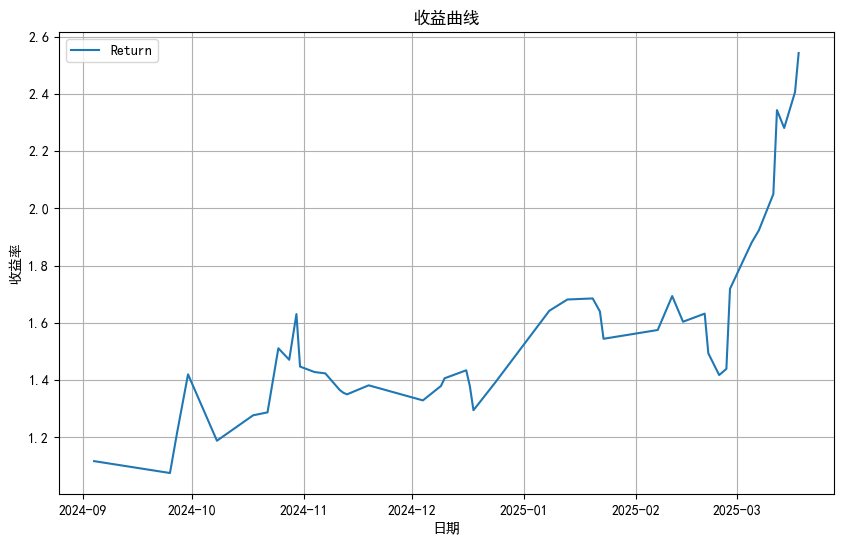

In [22]:
plot(ddwndx, 'cumulative_returns')

In [23]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_41520\2979096706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']


In [24]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-08,1347,追涨,小高开追涨,002730.XSHE,电光科技,1,"000003.BKDL,000023.BKDL,000035.BKDL,000006.BKD...","885517.DDBK,885729.DDBK,885700.DDBK,885619.DDB...",980365.ZHBK,1,1,4,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0.0,0.0,219.10,1.27,0.07,14.11,15.51,-1.0,16.43,17.06,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-115.79,4.24,74,-117.01,1.12,74,2025-02-15 21:39:08,37344527.0,0.164422,0.163422,0.209072,0.208072,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.44,0.180440,1.642469,1.023388
2025-03-12,1862,追涨,小高开追涨,002093.XSHE,国脉科技,2,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885522.DDBK,885617.DDBK,886041.DDBK,885456.DDB...","980753.ZHBK,980473.ZHBK,980376.ZHBK",2,2,2,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0.0,0.0,152.29,1.42,0.18,11.38,12.06,-1.0,11.73,13.27,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,76.06,-4.45,14,-30.85,-2.28,41,2025-03-13 08:02:37,57754638.0,0.030756,0.029756,0.166081,0.165081,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,11.60,0.142966,2.343119,1.019332
2024-12-24,2405,追涨,小高开追涨,002265.XSHE,建设工业,1,"000038.BKDL,000027.BKDL,000013.BKDL,000017.BKD...","885743.DDBK,885694.DDBK,886021.DDBK,885595.DDB...",980372.ZHBK,1,4,23,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,654.23,131.28,4.65,19.56,19.78,-1.0,19.84,21.38,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-17.96,23.45,33,-3.67,8.56,38,2025-02-15 21:29:14,75243408.0,0.014315,0.013315,0.093047,0.092047,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,19.88,0.074453,1.391404,1.016360
2025-02-26,3502,追涨,小高开追涨,002527.XSHE,新时达,1,"000038.BKDL,000018.BKDL,000035.BKDL,000027.BKD...","885775.DDBK,885517.DDBK,885619.DDBK,885694.DDB...","980365.ZHBK,980474.ZHBK",1,1,3,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0.0,0.0,172.91,3.37,0.11,18.33,17.76,-1.0,17.58,18.90,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-22.61,-31.71,68,-64.70,-12.95,72,2025-02-28 17:47:36,96403647.0,-0.040917,-0.041917,0.031097,0.030097,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,18.60,0.015129,1.439378,1.014730
2025-03-05,813,追涨,小高开追涨,601789.XSHG,宁波建工,1,"000003.BKDL,000008.BKDL,000023.BKDL,000011.BKD...","886021.DDBK,885757.DDBK,885957.DDBK,885690.DDB...",980338.ZHBK,2,1,27,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,153.16,5.23,0.32,6.32,6.38,-1.0,6.25,7.02,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,-75.19,-8.70,44,-67.81,0.52,66,2025-03-06 08:02:38,49895768.0,-0.011076,-0.012076,0.110759,0.109759,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.41,0.094164,1.880641,1.014241
2024-12-18,2348,追涨,小高开追涨,000863.XSHE,三湘印象,1,"000012.BKDL,000003.BKDL,000038.BKDL,000018.BKD...","886017.DDBK,885832.DDBK,885694.DDBK,885934.DDB...",980358.ZHBK,1,1,15,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,177.76,15.23,4.01,4.93,5.21,-1.0,5.00,4.70,-1.0,-1.0,-1.0,-1.0,0,0,9G0019,小高开追涨,29.95,-27.62,11,8.78,-0.73,36,2025-02-15 

<Axes: ylabel='Frequency'>

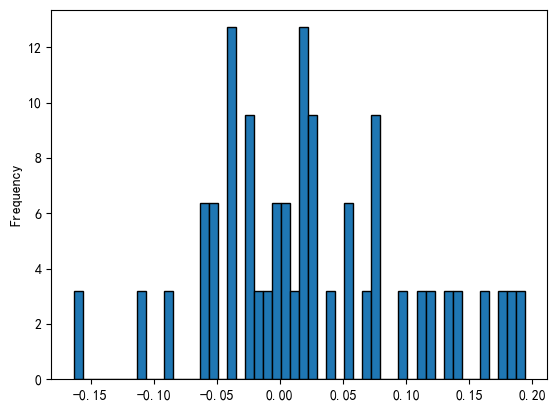

In [25]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [26]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [27]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [28]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%
